In [1]:
import os
# Change native directory to root
os.chdir(os.path.dirname(os.getcwd()))

In [89]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from optuna.samplers import TPESampler
from utils.group_ts_split import GroupTimeSeriesSplit, PurgedGroupTimeSeriesSplit

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve

In [40]:
data_train = pd.read_csv('data/extra_train.csv', index_col=0)
data_test = pd.read_csv('data/extra_test.csv', index_col=0)
data_train

,Month,Hour,cons_target,Solar Generation [W/kW],Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],day_year,number,...,net,net_target,net+1,net-23,net_target+1,net_target-23,diffuse_solar_radiation+1,direct_solar_radiation+1,relative_humidity+1,drybulb_temp+1
0,8.0,22.0,0.441346,0.000000,19.4,81.0,0.000000,0.000000,23,1,...,3.557083,0.617429,1.411333,2.275800,0.431845,0.506612,0.000000,0.000000,81.0,20.0
1,8.0,23.0,0.170776,0.000000,20.0,81.0,0.000000,0.000000,24,1,...,1.411333,0.431845,0.979417,0.851167,0.394489,0.383397,0.000000,0.000000,87.0,19.4
2,8.0,24.0,0.116313,0.000000,19.4,87.0,0.000000,0.000000,25,1,...,0.979417,0.394489,0.900975,0.834600,0.387705,0.381964,0.000000,0.000000,87.0,19.4
3,8.0,1.0,0.106422,0.000000,19.4,87.0,0.000000,0.000000,26,1,...,0.900975,0.387705,0.922433,0.838167,0.389561,0.382273,0.000000,0.000000,90.0,19.4
4,8.0,2.0,0.109127,0.000000,19.4,90.0,0.000000,0.000000,27,1,...,0.922433,0.389561,0.910483,1.478433,0.388527,0.437649,0.000000,0.000000,90.0,18.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43675,7.0,17.0,0.802751,31.179167,21.1,81.0,5.389072,5.669881,8754,5,...,3.839883,0.862123,2.713900,3.463783,0.720845,0.814933,3.295837,4.875197,84.0,20.6
43676,7.0,18.0,0.552807,4.070833,20.6,84.0,3.295837,4.875197,8755,5,...,2.713900,0.720845,0.935833,0.457167,0.497751,0.437693,0.000000,0.000000,81.0,21.1
43677,7.0,19.0,0.189487,0.000000,21.1,81.0,0.000000,0.000000,8756,5,...,0.935833,0.497751,2.155017,0.714717,0.650722,0.470007,0.000000,0.000000,79.0,21.7
43678,7.0,20.0,0.436347,0.000000,21.7,79.0,0.000000,0.000000,8757,5,...,2.155017,0.650722,2.316400,1.659000,0.670971,0.588487,0.000000,0.000000,76.0,21.3


In [64]:
features = ['Month', 'Hour', 'hour_x', 'hour_y', 'month_x', 'month_y',
'net_target-23', 'diffuse_solar_radiation+1', 'relative_humidity+1', 'drybulb_temp+1']
target = 'net_target+1'
qts = np.concatenate([[0.001],np.arange(0.05,0.951,0.05),[0.999]])
# round to 3 decimals
qts = np.round(qts, 3)
groups = data_train['day_year'].values

In [95]:
# run several lgb models for multiple quantiles
def run_lgb(data, datat, features, target, quantile, params, seed=42):
    # set seed
    X_temp = data[features]
    y_temp = data[target]
    params = {
    'objective': 'quantile',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'verbose': -1
    }
    params['seed'] = seed
    params['metric'] = 'quantile'
    params['alpha'] = quantile
    lgb_train = lgb.Dataset(X_temp, y_temp)
    best_model =  lgb.train(params, lgb_train, num_boost_round=200)
    y_pred = best_model.predict(data[features])
    y_pred_test = best_model.predict(datat[features])
    return y_pred, y_pred_test

# produce 5 quantile forecasts with uniform weights and output the dataframe with 5 columns
def run_lgb_ensemble(data, datat, features, target, seed=42):
    y_preds = []
    y_preds_test = []
    for quantile in qts:
        y_pred, y_pred_test = run_lgb(data, datat, features, target, quantile, seed)
        y_preds.append(y_pred)
        y_preds_test.append(y_pred_test)
    y_preds = np.array(y_preds).T
    y_preds_test = np.array(y_preds_test).T
    y_preds = pd.DataFrame(y_preds, columns=qts, index=data.timestamp)
    y_preds['number'] = data['number'].values
    y_preds['day_year'] = data['day_year'].values
    y_preds_test = pd.DataFrame(y_preds_test, columns=qts, index=datat.timestamp)
    y_preds_test['number'] = datat['number'].values
    y_preds_test['day_year'] = datat['day_year'].values
    return y_preds, y_preds_test

In [96]:

output, output_test = run_lgb_ensemble(data_train, data_test, features, target, seed=42)

In [97]:
def post_process(data):
    # sort column names
    #data = data[sorted(data.columns)]
    data.index = pd.to_datetime(data.index)
    data['hour'] = data.index.hour
    return data

output = post_process(output)
output_test = post_process(output_test)

In [94]:
output

,0.001,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,...,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.999,number,hour
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-07-31 21:00:00,0.322883,0.383452,0.413785,0.431443,0.444508,0.456197,0.461880,0.472461,0.491571,0.494161,...,0.549168,0.556131,0.572204,0.602189,0.641947,0.686733,0.746369,0.860502,1,21
2021-08-01 22:00:00,0.338289,0.361590,0.371128,0.373164,0.375278,0.378782,0.380464,0.382798,0.385171,0.386062,...,0.407861,0.420209,0.425590,0.452466,0.470609,0.525271,0.589980,0.787205,1,22
2021-08-01 23:00:00,0.345352,0.361546,0.370288,0.373332,0.375271,0.378129,0.379995,0.382583,0.382851,0.386352,...,0.405649,0.415988,0.416176,0.430124,0.441633,0.500803,0.532917,0.744893,1,23
2021-08-01 00:00:00,0.331988,0.360662,0.368349,0.371216,0.373884,0.375455,0.376025,0.378864,0.379295,0.382737,...,0.392773,0.400082,0.404158,0.415416,0.426367,0.455668,0.490970,0.728661,1,0
2021-08-01 01:00:00,0.324950,0.379630,0.410492,0.420451,0.427570,0.434322,0.435179,0.436782,0.437027,0.438343,...,0.445800,0.450469,0.458898,0.475228,0.488172,0.510236,0.549509,0.800668,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-30 16:00:00,0.300362,0.422021,0.455104,0.530801,0.542858,0.588118,0.600280,0.637452,0.641795,0.649856,...,0.708942,0.725742,0.760222,0.793425,0.811300,0.835018,0.875491,0.807802,5,16
2022-07-30 17:00:00,0.319181,0.380770,0.396219,0.411757,0.422813,0.429266,0.433115,0.441603,0.442054,0.451250,...,0.487879,0.493604,0.510791,0.529246,0.557017,0.608167,0.660644,0.841968,5,17
2022-07-30 18:00:00,0.323339,0.384611,0.411142,0.430256,0.440105,0.455556,0.465402,0.474146,0.477585,0.499881,...,0.523876,0.539979,0.553502,0.576317,0.605207,0.644079,0.688531,0.855566,5,18


In [93]:
def get_plot_from_files(real_power, quantiles):
    real_below_counter = [0 for _ in qts]
    real_tot = 0

    sample_below_counter = [0 for _ in qts]
    sample_tot = 0


    for _, row in quantiles.iterrows():
        build_num = int(row["number"])
        time_step = int(row["day_year"])
        if time_step == real_power.shape[0]-1:
            break
        real_power = data_train.loc[data_train['number'] == build_num, 'net_target+1'][time_step]
        
        for i, quant_bnd in enumerate(qts):
            quant_val =row[quant_bnd]
            if real_power<quant_val:
                real_below_counter[i] += 1
        real_tot += 1
    
    quantiles = quantiles.columns[2:]
    quant_float = [float(i)for i in quantiles]

    real_below_norm = [i/real_tot for i in real_below_counter]

    sample_below_norm = [i/sample_tot for i in sample_below_counter]
    
    plot_both_cumul([quant_float]*2,[real_below_norm, sample_below_norm], ["Real powers", "Sample powers"])
    return quant_float,real_below_norm

def plot_both_cumul(quantiles_bnd, quantile_proportion, labels):
    fig = plt.figure()
    ax = fig.add_subplot()

    plt.plot([0,1],[0,1])
    for i, val in enumerate(quantiles_bnd):
        plt.scatter(val, quantile_proportion[i], label=labels[i])
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel("Quantiles")
    plt.ylabel("Proportion of points below this quantile")
    plt.legend()

y_true takes value in {0.0, 0.0002116023491708, 0.0019544362432503, 0.0021795041964592, 0.0025969379216417, 0.0041781845672635, 0.0050423075330807, 0.0053882634530176, 0.0078142793415753, 0.008683390946882, 0.0087036743524132, 0.0090950536989052, 0.010807109069469, 0.0112349184999517, 0.0114468165009132, 0.0119035939697177, 0.0129243365756438, 0.0130366283666414, 0.0132636199775701, 0.0137560763538221, 0.0145023874969542, 0.0146349074711341, 0.0148011474413016, 0.0148141207882991, 0.0152571826491371, 0.0161013651070645, 0.0163895637721389, 0.0164895939735651, 0.0165020973809916, 0.0167396694771305, 0.0167531350811687, 0.0168829783154046, 0.0168941807569201, 0.017080132063886, 0.0171046372748816, 0.017185958068109, 0.0172862641328487, 0.0178553909545766, 0.017898894407737, 0.0185440604182415, 0.0186652508545849, 0.0187498917942531, 0.0188614639419978, 0.0188646880175606, 0.0190769136066081, 0.0191112105579034, 0.0191803727945031, 0.019309676190696, 0.0193904698149248, 0.0195733593196166

In [91]:
output[qts]

,0.001,0.050,0.100,0.150,0.200,0.250,0.300,0.350,0.400,0.450,...,0.550,0.600,0.650,0.700,0.750,0.800,0.850,0.900,0.950,0.999
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-07-31 21:00:00,0.322883,0.383452,0.413785,0.431443,0.444508,0.456197,0.461880,0.472461,0.491571,0.494161,...,0.520553,0.535095,0.549168,0.556131,0.572204,0.602189,0.641947,0.686733,0.746369,0.860502
2021-08-01 22:00:00,0.338289,0.361590,0.371128,0.373164,0.375278,0.378782,0.380464,0.382798,0.385171,0.386062,...,0.389439,0.400302,0.407861,0.420209,0.425590,0.452466,0.470609,0.525271,0.589980,0.787205
2021-08-01 23:00:00,0.345352,0.361546,0.370288,0.373332,0.375271,0.378129,0.379995,0.382583,0.382851,0.386352,...,0.388892,0.396680,0.405649,0.415988,0.416176,0.430124,0.441633,0.500803,0.532917,0.744893
2021-08-01 00:00:00,0.331988,0.360662,0.368349,0.371216,0.373884,0.375455,0.376025,0.378864,0.379295,0.382737,...,0.383596,0.387807,0.392773,0.400082,0.404158,0.415416,0.426367,0.455668,0.490970,0.728661
2021-08-01 01:00:00,0.324950,0.379630,0.410492,0.420451,0.427570,0.434322,0.435179,0.436782,0.437027,0.438343,...,0.441232,0.441787,0.445800,0.450469,0.458898,0.475228,0.488172,0.510236,0.549509,0.800668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-30 16:00:00,0.300362,0.422021,0.455104,0.530801,0.542858,0.588118,0.600280,0.637452,0.641795,0.649856,...,0.681506,0.698387,0.708942,0.725742,0.760222,0.793425,0.811300,0.835018,0.875491,0.807802
2022-07-30 17:00:00,0.319181,0.380770,0.396219,0.411757,0.422813,0.429266,0.433115,0.441603,0.442054,0.451250,...,0.468657,0.475964,0.487879,0.493604,0.510791,0.529246,0.557017,0.608167,0.660644,0.841968
2022-07-30 18:00:00,0.323339,0.384611,0.411142,0.430256,0.440105,0.455556,0.465402,0.474146,0.477585,0.499881,...,0.510147,0.517266,0.523876,0.539979,0.553502,0.576317,0.605207,0.644079,0.688531,0.855566


In [88]:
# predicted quantiles vs actual quantiles
def plot_qq(data, data_test, qts):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for quantile in qts:
        sns.kdeplot(output_test[quantile], label=quantile, ax=ax)
    plt.legend()
    plt.show()

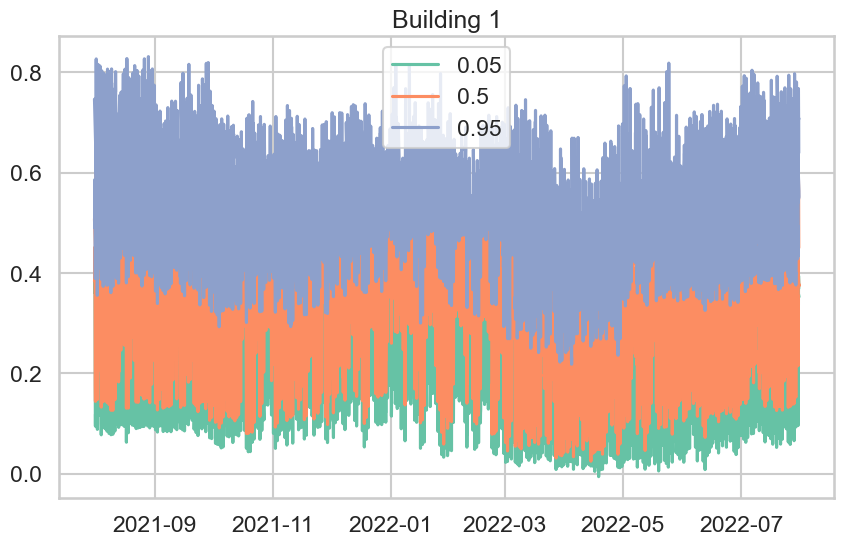

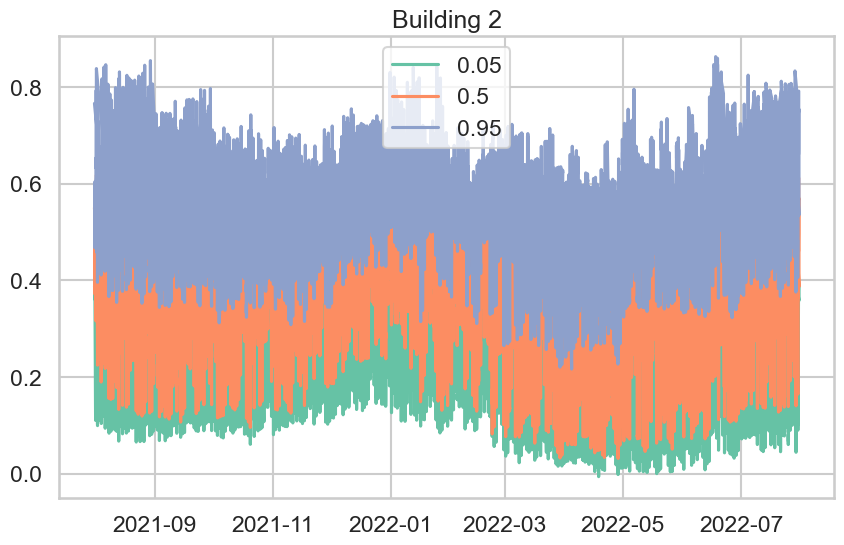

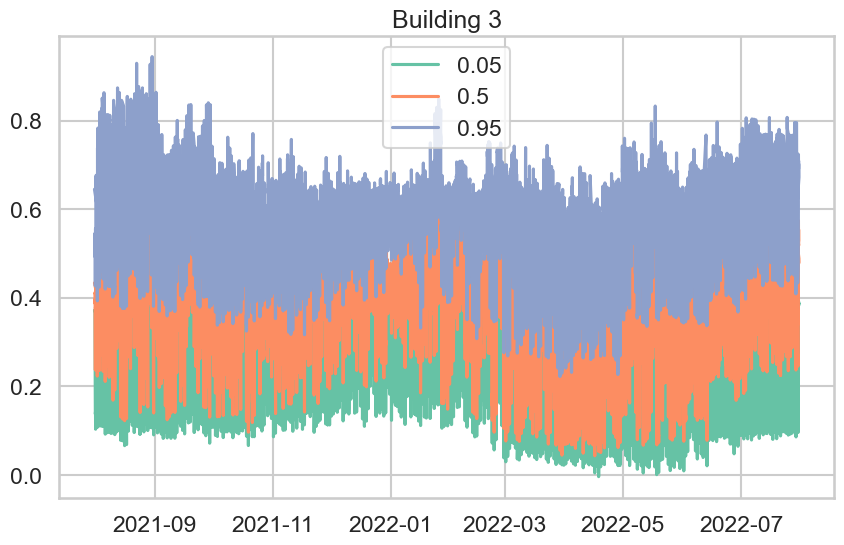

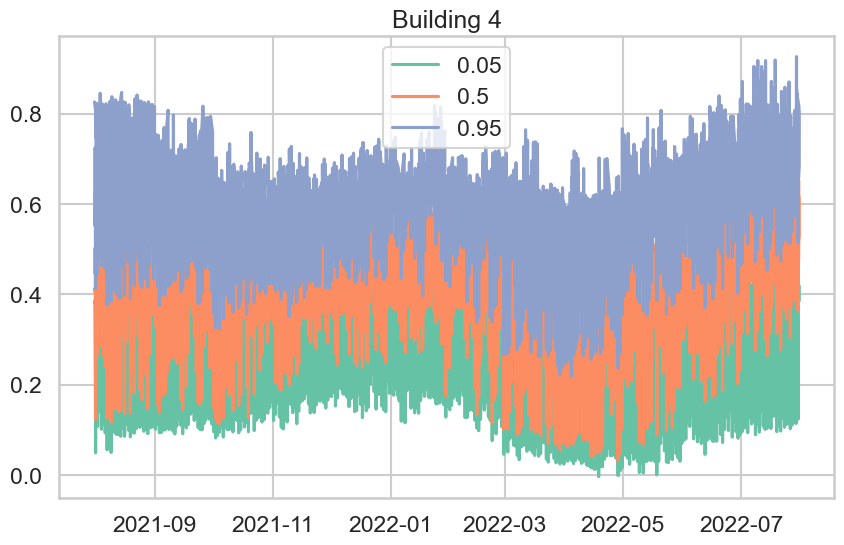

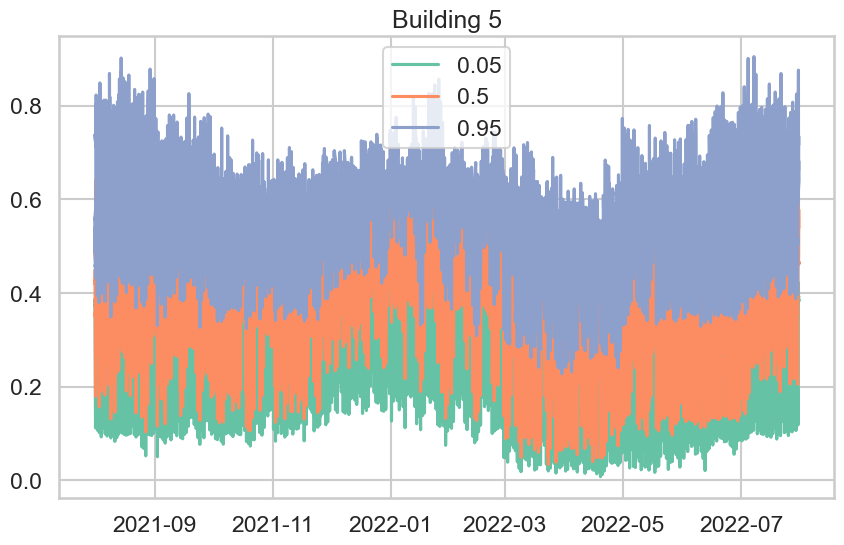

In [84]:
# quantile calibration plot
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('Set2')
for build in output.number.unique():
    plt.figure(figsize=(10, 6))
    plt.title(f'Building {build}')
    plt.plot(output.loc[output.number==build, 0.05], label='0.05')
    plt.plot(output.loc[output.number==build, 0.5], label='0.5')
    plt.plot(output.loc[output.number==build, 0.95], label='0.95')
    plt.legend()
    plt.show()

In [13]:
output.to_csv('./data/quantile/year_qs.csv', index=True)
output_test.to_csv('./data/quantile/year_qs_test.csv', index=True)

In [5]:
output = pd.read_csv('./data/quantile/year_qs.csv', index_col=0)
output 

,0.001,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,...,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.999,hour
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-08-02 00:00:00,0.303144,0.369353,0.376349,0.380305,0.382202,0.382707,0.386298,0.387832,0.387259,0.388268,...,0.399557,0.402965,0.402966,0.409924,0.421649,0.438896,0.460093,0.489065,0.747136,0
2021-08-02 01:00:00,0.305496,0.369540,0.377217,0.382645,0.382997,0.384135,0.384699,0.385413,0.386054,0.385496,...,0.389481,0.392013,0.397967,0.398482,0.411848,0.424562,0.448965,0.494651,0.743658,1
2021-08-02 02:00:00,0.286406,0.371241,0.378363,0.381176,0.383090,0.384410,0.386936,0.387737,0.388410,0.388770,...,0.395280,0.403726,0.403535,0.408394,0.414624,0.428989,0.438694,0.495129,0.743658,2
2021-08-02 03:00:00,0.286969,0.371241,0.379088,0.383727,0.384219,0.385751,0.387749,0.387367,0.389014,0.388077,...,0.394311,0.395869,0.404769,0.410257,0.416182,0.426240,0.438164,0.490161,0.740722,3
2021-08-02 04:00:00,0.269961,0.351769,0.362449,0.374904,0.375802,0.374120,0.382955,0.387517,0.391618,0.388278,...,0.405398,0.407918,0.412246,0.419744,0.426758,0.437952,0.455525,0.499027,0.741087,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-30 19:00:00,0.307131,0.381668,0.404760,0.413892,0.424813,0.441078,0.439176,0.443101,0.446479,0.463930,...,0.479411,0.492119,0.500108,0.497599,0.522463,0.539418,0.566452,0.635146,0.820193,19
2022-07-30 20:00:00,0.313776,0.384778,0.418112,0.438087,0.446400,0.462508,0.463368,0.468091,0.473173,0.490476,...,0.512539,0.519381,0.525012,0.522898,0.559484,0.571380,0.597751,0.671609,0.817159,20
2022-07-30 21:00:00,0.332102,0.392807,0.432249,0.449053,0.467606,0.480640,0.491217,0.512607,0.520690,0.540575,...,0.585383,0.594138,0.599300,0.618007,0.639146,0.651856,0.683629,0.750670,0.845875,21


In [6]:
data_train

,Month,Hour,cons_target,Solar Generation [W/kW],Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],day_year,number,...,net,net_target,net+1,net-23,net_target+1,net_target-23,diffuse_solar_radiation+1,direct_solar_radiation+1,relative_humidity+1,drybulb_temp+1
0,8.0,22.0,0.441346,0.000000,19.4,81.0,0.000000,0.000000,23,1,...,3.557083,0.617429,1.411333,2.275800,0.431845,0.506612,0.000000,0.000000,81.0,20.0
1,8.0,23.0,0.170776,0.000000,20.0,81.0,0.000000,0.000000,24,1,...,1.411333,0.431845,0.979417,0.851167,0.394489,0.383397,0.000000,0.000000,87.0,19.4
2,8.0,24.0,0.116313,0.000000,19.4,87.0,0.000000,0.000000,25,1,...,0.979417,0.394489,0.900975,0.834600,0.387705,0.381964,0.000000,0.000000,87.0,19.4
3,8.0,1.0,0.106422,0.000000,19.4,87.0,0.000000,0.000000,26,1,...,0.900975,0.387705,0.922433,0.838167,0.389561,0.382273,0.000000,0.000000,90.0,19.4
4,8.0,2.0,0.109127,0.000000,19.4,90.0,0.000000,0.000000,27,1,...,0.922433,0.389561,0.910483,1.478433,0.388527,0.437649,0.000000,0.000000,90.0,18.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43675,7.0,17.0,0.802751,31.179167,21.1,81.0,5.389072,5.669881,8754,5,...,3.839883,0.862123,2.713900,3.463783,0.720845,0.814933,3.295837,4.875197,84.0,20.6
43676,7.0,18.0,0.552807,4.070833,20.6,84.0,3.295837,4.875197,8755,5,...,2.713900,0.720845,0.935833,0.457167,0.497751,0.437693,0.000000,0.000000,81.0,21.1
43677,7.0,19.0,0.189487,0.000000,21.1,81.0,0.000000,0.000000,8756,5,...,0.935833,0.497751,2.155017,0.714717,0.650722,0.470007,0.000000,0.000000,79.0,21.7
43678,7.0,20.0,0.436347,0.000000,21.7,79.0,0.000000,0.000000,8757,5,...,2.155017,0.650722,2.316400,1.659000,0.670971,0.588487,0.000000,0.000000,76.0,21.3
